# Data Cleaning

In [1]:
%reload_ext autoreload
%autoreload 2

# File imports
import signin_config
from book_functions import *

# Base imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# NLP imports
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from scipy import stats
import nltk
from nltk.corpus import gutenberg, stopwords
from nltk.collocations import *
from nltk import FreqDist
from nltk import word_tokenize
import string
import re
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

# !pip install rake-nltk
from rake_nltk import Rake


# scraping imports
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

In [2]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)


## Clean data 

- look for nan values, empty descriptions, clean types (str -> int), (organize pictures)
    ratings, number of ratings, pages (str -> int)


Merging with other dataframe -->

In [31]:
# df = pd.read_csv('goodread_data2_reb1.csv')
# df1 = df1 = pd.read_csv('cleaned_gr_data_quan2.csv')
# df_genres = pd.concat([df,df1], sort=True)
# df_parent = pd.concat([df,df1], sort=True)

In [32]:
# df_genres.drop(['Unnamed: 0','format'], axis=1, inplace=True) # drop format and random first column
# df_genres.pages = df_genres.pages.apply(lambda x: float(str(x).split(' ')[0]))
# df_genres.genre = df_genres.genre.apply(lambda x: x.replace('{','').replace('}',''))
# df_genres.genre = df_genres.genre.apply(lambda x: x.replace("'",''))
# df_genres['genre'] = df_genres['genre'].map(lambda x: x.lower().split(','))

In [135]:
df = pd.read_csv('goodread_img1.csv')
df.drop(['Unnamed: 0'], axis=1,inplace=True)#,'pages','format'], axis=1,inplace=True)

In [41]:
df.genre = df.genre.apply(lambda x: x.replace('{','').replace('}',''))
df.genre = df.genre.apply(lambda x: x.replace("'",''))
df['genre'] = df['genre'].map(lambda x: x.lower().split(','))

## NLP cleaning

Filtering, Stemming, Lemming and TF-IDF to produce an nlp-friendly dataset named 'nlp'

Functions to clean:

In [42]:
# new stopwords_list and regex pattern

pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
stopwords_list = stopwords.words('english')
stopwords_list += list(string.punctuation)
stopwords_list += ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
stopwords_list += ['book', 'author', 'novel', 'year', 'come', 'stories','story','thing','alex', 'stephanie', 
                   'bestseller']

In [43]:
nlp = pd.DataFrame(df.description)
nlp['describe_raw'] = nlp.description.apply(lambda info: nltk.regexp_tokenize(info, pattern));
nlp['raw_token'] = nlp.describe_raw.apply(lambda x: [word.lower() for word in x]);
nlp['token_list'] = nlp.raw_token.apply(lambda x : [word for word in x if word not in stopwords_list]);
nlp['freq_dist'] = nlp.describe_raw.apply(lambda x: FreqDist(x));
nlp['freq_dist_top'] = nlp.freq_dist.apply(lambda x: x.most_common(20));

# apply tfidf to vectorize
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0, stop_words='english')
nlp['tfidf'] = tf.fit_transform(nlp['description'])

# TF-IDF Content-Based Recommendation System

## Based on Description
Cosine Similarities:


In [44]:
ds = df.copy(deep=False)

#getting stuck at 3998 for some reason
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(ds['description'])

cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)

results = {}

for idx, row in ds.iterrows():
    similar_indices = cosine_similarities[idx].argsort()[:-100:-1] # not sure why this is here
    similar_items = [(cosine_similarities[idx][i], ds['id'][i]) for i in similar_indices]

    results[row['id']] = similar_items[1:]
    
print('done!')


KeyboardInterrupt: 

In [106]:
df.description.

,titles,authors,ratings,num_ratings,id,img,description,genre,key_words
0,"Anne of Avonlea (Anne of Green Gables, #2)",l.m.montgomery,4.22,126781,77390,https://i.gr-assets.com/images/S/compressed.ph...,At sixteen Anne is grown upalmost Her gray eye...,"[childrens, classics, historical, historicalfi...","[temper, arrived, avonlea, people, red, hair, ..."
1,Ethan Frome,edithwharton,3.39,100785,5246,https://i.gr-assets.com/images/S/compressed.ph...,He seemed a part of the mute melancholy landsc...,"[classics, academic, fiction, school, literature]","[seemed, hypochondriac, wife, zeena, possibili..."
2,The Arabian Nights,anonymous,4.05,70660,93101,https://i.gr-assets.com/images/S/compressed.ph...,The tales of told by Shahrazad over a thousand...,"[classics, shortstories, fantasy, fiction]","[bottles, one, nights, told, tale, intimate, r..."
3,Martin Eden,jacklondon,4.43,21445,929782,https://i.gr-assets.com/images/S/compressed.ph...,Alternate cover edition of ISBN The semiauto...,"[classics, american, literature, fiction]","[story, aggressively, dreams, eden, san, franc..."
4,"A Girl of the Limberlost (Limberlost, #2)",genestratton-porter,4.15,17932,17567,https://i.gr-assets.com/images/S/compressed.ph...,Set amid Indianas vast Limberlost Swamp this t...,"[childrens, classics, historical, historicalfi...","[northern, indiana, oil, production, gene, str..."


In [ ]:
recommend(item_id=11, num=5)

# Get Keywords

In [12]:
dff = pd.read_csv('goodreads_updated.csv')
dff.drop('Unnamed: 0', axis=1,inplace=True)
dff = dff.iloc[:7000]

In [28]:
# create author and genre column clean
dff['au_ge'] = dff.authors.apply(lambda x: x.lower().replace(' ','')) + ' ' + dff.genre.apply(lambda x: x.replace(' ','').replace(',',' ') if x!='set()' and type(x)!=float else ' ')
dff['au_ge'] = dff.au_ge.apply(lambda x: x.lower() if type(x) != float else x)  # run this line before bow

In [32]:
# clean description for keyword search

dff['desc_clean'] = dff.description
for c in string.punctuation:
    dff.desc_clean = dff.desc_clean.apply(lambda x: x.replace(c,"") if type(x)!=float else x)
for s in string.digits:
    dff.desc_clean = dff.desc_clean.apply(lambda x: x.replace(s,"") if type(x)!=float else x)
    dff.desc_clean = dff.desc_clean.apply(lambda x: x.replace('”','') if type(x)!=float else x)
    dff.desc_clean = dff.desc_clean.apply(lambda x: x.replace('“','') if type(x)!=float else x)

In [35]:
dff['key_words'] = ""
for idx, row in dff.iterrows():
    plot = row['desc_clean']
    if type(plot) == float:
        continue
    
    # instantiating Rake, by default is uses english stopwords from NLTK
    # and discard all puntuation characters
    r = Rake()
    # extracting the words by passing the text
    r.extract_keywords_from_text(plot)
    # getting the dictionary with key words and their scores
    key_words_dict_scores = r.get_word_degrees()

    # assigning the key words to the new column
    keys = list(key_words_dict_scores.keys())
    keys = ' '.join(keys)
    dff.loc[idx, 'key_words'] = keys

In [37]:
dff['bag_of_words'] = dff.au_ge.apply(lambda x: x if type(x)!=float else '') + ' ' + dff.key_words.apply(lambda x: x if type(x)!=float else '')

In [38]:
dff.sample(5)

,titles,authors,ratings,num_ratings,id,img,description,pages,genre,format,isbn,au_ge,desc_clean,key_words,bag_of_words
1056,The Appetite of Tyranny: Including Letters to ...,Charles Bryce,3.36,89,6218430,https://i.gr-assets.com/images/S/compressed.ph...,This book was converted from its physical edit...,0,"History, Politics, Nonfiction, Writing, Essays...",NaN,NaN,charlesbryce history politics nonfiction writi...,This book was converted from its physical edit...,free may find web purchase physical edition di...,charlesbryce history politics nonfiction writi...
1077,Bones (Sanders of the River #5),Franz Kafka,3.63,62,8305682,https://i.gr-assets.com/images/S/compressed.ph...,It is a time when the major world powers are v...,NaN,"Mystery, Crime, Classics",NaN,NaN,franzkafka mystery crime classics,It is a time when the major world powers are v...,trusty lieutenant hamilton takes colonial hono...,franzkafka mystery crime classics trusty lieut...
2841,The Human Voice: A Play = La Voix Humaine,Jean Cocteau,4.03,271,80276,https://i.gr-assets.com/images/S/compressed.ph...,"""Une femme seule dans une chambre en désordre ...",NaN,"Plays, Plays, Theatre, Drama, Cultural, France",paperback,9780573033810,jeancocteau plays plays theatre drama cultural...,Une femme seule dans une chambre en désordre t...,une femme seule dans chambre en désordre télép...,jeancocteau plays plays theatre drama cultural...
2562,"Tarzan and the Golden Lion (Tarzan, #9)",Edgar Rice Burroughs,3.76,1373,828196,https://i.gr-assets.com/images/S/compressed.ph...,Tarzan had been betrayed. Drugged and helpless...,191,"Fantasy, Adventure, Fiction, Classics",mass market paperback,9780345289988,edgarriceburroughs fantasy adventure fiction c...,Tarzan had been betrayed Drugged and helpless ...,flaming god opar last bastion dreadful priests...,edgarriceburroughs fantasy adventure fiction c...
6047,Shackleton's Boat Journey,Emil M. Cioran,4.31,760,222233,https://i.gr-assets.com/images/S/compressed.ph...,This is an account of the Shackleton boat jour...,164,"History, Nonfiction, Adventure, Biography, Travel",paperback,9781841580630,emilm.cioran history nonfiction adventure biog...,This is an account of the Shackleton boat jour...,breathtaking survival stories getting antarcti...,emilm.cioran history nonfiction adventure biog...


In [40]:
dff.to_json(r'goodreads_updated.json',orient='index')

# Bag of Words

In [524]:
dff['bag_of_words'] = dff.au_ge + ' ' + dff.key_words

TypeError: can only join an iterable

Stop here - clean below before final push

# NLP Topic Modeling

## Preprocessing data

In [130]:
processed_docs = df['description'].map(preprocess)

In [131]:
dictionary = gensim.corpora.Dictionary(processed_docs)

In [132]:
dictionary.filter_extremes(no_below=20, no_above=0.66, keep_n=10000)

## Bag of Words on dataset

In [133]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

In [134]:
bow_doc_2001 = bow_corpus[2001]

In [135]:
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

In [140]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=4, workers=2)

In [141]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.021*"love" + 0.012*"life" + 0.010*"famili" + 0.010*"world" + 0.009*"girl" + 0.009*"know" + 0.008*"night" + 0.008*"secret" + 0.007*"power" + 0.007*"live"
Topic: 1 
Words: 0.011*"time" + 0.010*"life" + 0.009*"girl" + 0.009*"want" + 0.007*"world" + 0.007*"like" + 0.007*"know" + 0.007*"think" + 0.007*"secret" + 0.007*"peopl"
Topic: 2 
Words: 0.013*"famili" + 0.013*"life" + 0.011*"live" + 0.010*"love" + 0.009*"world" + 0.007*"time" + 0.006*"year" + 0.006*"work" + 0.005*"write" + 0.005*"woman"
Topic: 3 
Words: 0.015*"world" + 0.013*"love" + 0.010*"vampir" + 0.009*"live" + 0.009*"power" + 0.008*"magic" + 0.008*"secret" + 0.008*"life" + 0.007*"human" + 0.006*"danger"
Topic: 4 
Words: 0.013*"know" + 0.011*"dead" + 0.011*"world" + 0.008*"want" + 0.008*"like" + 0.007*"time" + 0.007*"life" + 0.006*"bestsel" + 0.006*"power" + 0.006*"rise"
Topic: 5 
Words: 0.013*"world" + 0.007*"live" + 0.006*"life" + 0.006*"famili" + 0.006*"lose" + 0.005*"take" + 0.005*"dead" + 0.005*"bestsel" + 

In [142]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.003*"love" + 0.003*"life" + 0.003*"time" + 0.003*"kate" + 0.003*"live" + 0.002*"famili" + 0.002*"know" + 0.002*"want" + 0.002*"world" + 0.002*"woman"
Topic: 1 Word: 0.003*"girl" + 0.003*"love" + 0.003*"world" + 0.003*"famili" + 0.003*"secret" + 0.003*"time" + 0.002*"know" + 0.002*"life" + 0.002*"father" + 0.002*"live"
Topic: 2 Word: 0.003*"world" + 0.003*"life" + 0.002*"live" + 0.002*"love" + 0.002*"know" + 0.002*"famili" + 0.002*"time" + 0.002*"like" + 0.002*"think" + 0.002*"power"
Topic: 3 Word: 0.003*"love" + 0.003*"life" + 0.003*"want" + 0.003*"know" + 0.003*"friend" + 0.003*"world" + 0.002*"famili" + 0.002*"secret" + 0.002*"time" + 0.002*"live"
Topic: 4 Word: 0.003*"life" + 0.003*"love" + 0.003*"know" + 0.003*"famili" + 0.003*"friend" + 0.002*"time" + 0.002*"leav" + 0.002*"girl" + 0.002*"come" + 0.002*"world"
Topic: 5 Word: 0.004*"love" + 0.003*"vampir" + 0.003*"life" + 0.003*"famili" + 0.002*"world" + 0.002*"live" + 0.002*"know" + 0.002*"power" + 0.002*"peopl" + 

In [148]:
processed_docs[7090447]

['mother',
 'death',
 'year',
 'carter',
 'kane',
 'live',
 'suitcas',
 'travel',
 'globe',
 'father',
 'brilliant',
 'egyptologist',
 'julius',
 'kane',
 'carter',
 'homeschool',
 'younger',
 'sister',
 'sadi',
 'live',
 'grandpar',
 'london',
 'sadi',
 'carter',
 'want',
 'school',
 'friend',
 'chanc',
 'normal',
 'life',
 'carter',
 'sadi',
 'long',
 'time',
 'father',
 'year',
 'live',
 'apart',
 'sibl',
 'common',
 'christma',
 'sadi',
 'carter',
 'reunit',
 'father',
 'bring',
 'british',
 'museum',
 'promis',
 'go',
 'thing',
 'right',
 'accord',
 'plan',
 'carter',
 'sadi',
 'watch',
 'julius',
 'summon',
 'mysteri',
 'figur',
 'quick',
 'banish',
 'father',
 'caus',
 'fieri',
 'explos',
 'soon',
 'carter',
 'sadi',
 'discov',
 'god',
 'ancient',
 'egypt',
 'wake',
 'worst',
 'frighten',
 'scheme',
 'save',
 'father',
 'embark',
 'danger',
 'journey',
 'quest',
 'bring',
 'closer',
 'truth',
 'famili',
 'link',
 'hous',
 'life',
 'secret',
 'order',
 'exist',
 'time',
 'pharaoh

In [ ]:
for index, score in sorted(lda_model[bow_corpus[4310]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))

In [ ]:
for index, score in sorted(lda_model_tfidf[bow_corpus[4310]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))

then on unseen document

## Topic Clustering

### Pearson Correlation

from https://github.com/nikitaa30/Content-based-Recommender-System/blob/master/recommender_system.py

## EDA of continuous data

In [248]:
df_genres.pages.describe()

count   4183.000
mean     380.532
std      191.497
min        2.000
25%      292.000
50%      356.000
75%      435.000
max     5216.000
Name: pages, dtype: float64

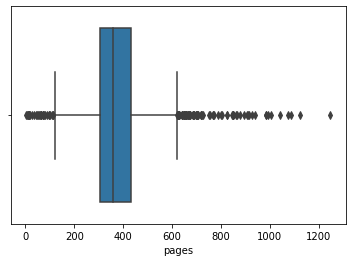

In [77]:
sns.boxplot(df_genres.pages);

In [102]:
df_genres.num_ratings.describe()

count      1990.000
mean      85340.892
std      160750.248
min         293.000
25%       29074.250
50%       47486.000
75%       83685.750
max     3140387.000
Name: num_ratings, dtype: float64

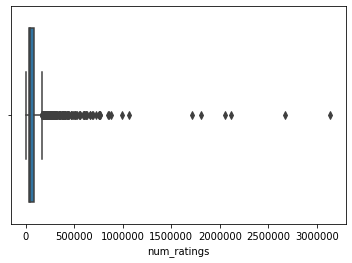

In [98]:
sns.boxplot(df_genres.num_ratings);

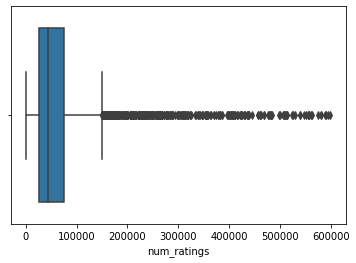

In [175]:
sns.boxplot(less.num_ratings)

In [166]:
len(df)/3

1394.3333333333333

In [168]:
len(df[(df.num_ratings > 80000)]) #& (df.num_ratings > 27000)])

1055

In [150]:
df.num_ratings.describe()

count      4183.000
mean      92458.276
std      222317.413
min         293.000
25%       27043.500
50%       44106.000
75%       80462.000
max     5851687.000
Name: num_ratings, dtype: float64

In [511]:
df = pd.read_csv('keywords.csv')